In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
import h5py
import pickle
import os
os.chdir("neuron_genetic_alg/neuron_files/allen")
from neuron import h
os.chdir("../../../")
print(os.getcwd())
import sys
import pandas as pd
np.set_printoptions(threshold=sys.maxsize)



/global/cscratch1/sd/zladd/allen_dataset


In [2]:
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

tick_major = 6
tick_minor = 4
plt.rcParams["xtick.major.size"] = tick_major
plt.rcParams["xtick.minor.size"] = tick_minor
plt.rcParams["ytick.major.size"] = tick_major
plt.rcParams["ytick.minor.size"] = tick_minor

font_small = 12
font_medium = 13
font_large = 14
plt.rc('font', size=font_small)          # controls default text sizes
plt.rc('axes', titlesize=font_medium)    # fontsize of the axes title
plt.rc('axes', labelsize=font_medium)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=font_small)    # fontsize of the tick labels
plt.rc('ytick', labelsize=font_small)    # fontsize of the tick labels
plt.rc('legend', fontsize=font_small)    # legend fontsize
plt.rc('figure', titlesize=font_large)   # fontsize of the figure title

# Plot for GA result
def final_indv_plot(param_names, final_best_indv, title, file_path_to_save=None, max_xtic=1, vert_size=10):
    plt.figure(figsize=(cm_to_in(8.5), cm_to_in(vert_size)))
    ax = plt.gca()
    y_pos = np.arange(len(param_names))
    ax.barh(y_pos, final_best_indv, height=0.5, align='center', linestyle='-', color='black')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(param_names)
    ax.invert_yaxis()  # labels read top-to-bottom
    plt.axvline(x=0, color='black', linewidth=0.4 ,linestyle='--')
    ax.set_xlim(0, max_xtic)
    ax.set_xticks([0, max_xtic])
    ax.set_ylabel('Parameters')
    ax.set_xlabel('Normalized Distance')
    ax.set_title('Deviation From Truth Value ' + title)
    if file_path_to_save:
        plt.savefig(file_path_to_save+'.pdf', format='pdf', dpi=1000, bbox_inches="tight")

# Code for optimization results analysis
def read_and_normalize_with_neg(opt_result_path, base, lower_bounds, upper_bounds):
    with open(opt_result_path, 'rb') as f:
        best_indvs = pickle.load(f, encoding = "latin1")
    normalized_indvs = []
    for i in range(len(best_indvs)):
        normalized = []
        for j in range(len(best_indvs[i])):
            if (best_indvs[i][j] < base[j]):
                new_value = abs((best_indvs[i][j] - base[j])/(ubs[j] - base[j]))
                normalized.append(new_value)
            else:
                new_value = abs((best_indvs[i][j] - base[j])/(ubs[j] - base[j]))
                normalized.append(new_value)
        normalized_indvs.append(normalized)
    return normalized_indvs, best_indvs

def plot_stim_volts_pair(stim, volts, title_stim, title_volts, file_path_to_save=None):
    plt.figure(figsize=(cm_to_in(8.5+6), cm_to_in(12)))
    plt.subplot(2, 1, 1)
    plt.title(title_stim)
    plt.xlabel('Time (ms)')
    plt.ylabel('Amplitude (nA)')
    plt.plot(stim, color='black', linewidth=0.7)
    plt.subplot(2, 1, 2)
    plt.title('Voltage Response '+title_volts)
    plt.xlabel('Time (ms)')
    plt.ylabel('Amplitude (mV)')
    plt.plot(volts[0], label='target', color='black')
    plt.plot(volts[1], label='best individual', color='crimson')
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    plt.tight_layout(pad=1)
    if file_path_to_save:
        plt.savefig(file_path_to_save+'.pdf', format='pdf', dpi=1000, bbox_inches="tight")

def cm_to_in(cm):
    return cm/2.54

# Running a single volt
def run_single_volts(param_set, stim_data, ntimestep, dt):
    run_file = 'neuron_genetic_alg/neuron_files/allen/run_model_cori.hoc'
    h.load_file(run_file)
    total_params_num = len(param_set)
    timestamps = np.array([dt for i in range(ntimestep)])
    h.curr_stim = h.Vector().from_python(stim_data)
    h.transvec = h.Vector(total_params_num, 1).from_python(param_set)
    h.stimtime = h.Matrix(1, len(timestamps)).from_vector(h.Vector().from_python(timestamps))
    h.ntimestep = ntimestep
    h.runStim()
    out = h.vecOut.to_python()
    return np.array(out)

def plot_comb_scores(opt_path, score_path, title, plot_save_path=None):
    opt_result = h5py.File(opt_path)
    ordered_score_function_list = [e.decode('ascii') for e in opt_result['ordered_score_function_list'][:]]
    optimization_stim_names = [e.decode('ascii') for e in opt_result['opt_stim_name_list'][:]]
    optimization_weightes = opt_result['opt_weight_list'][:]
    best_stims_score_list = []
    for score_name in optimization_stim_names:
        curr_score_data = h5py.File(score_path+score_name+'_scores.hdf5', 'r')
        for sf in ordered_score_function_list:
            curr_stim_sf_pair = curr_score_data['norm_pin_scores_'+sf][:]
            best_stims_score_list.append(curr_stim_sf_pair)
    combined_score = sum([best_stims_score_list[i]*optimization_weightes[i] for i in range(len(optimization_weightes))])
    plt.figure(figsize=(cm_to_in(8.5), cm_to_in(5)))
    plt.title(title)
    plt.xlabel('Parameter Set Rank')
    plt.ylabel('Weighted Score')
    time_step = range(len(combined_score))
    plt.scatter(time_step, combined_score, s=1, color='black')
    if plot_save_path:
        plt.savefig(plot_save_path+'.pdf', format='pdf', dpi=1000, bbox_inches="tight")


In [3]:
params_bbp = list(pd.read_csv('neuron_genetic_alg/params/params_bbp_full_gpu_tuned_10_based.csv').iloc[:,0])
print(params_bbp)

['g_pas_all', 'e_pas_all', 'gNaTa_tbar_NaTa_t_axonal', 'gK_Tstbar_K_Tst_axonal', 'gNap_Et2bar_Nap_Et2_axonal', 'gK_Pstbar_K_Pst_axonal', 'gSKv3_1bar_SKv3_1_axonal', 'gCa_LVAstbar_Ca_LVAst_axonal', 'gCa_HVAbar_Ca_HVA_axonal', 'gSKv3_1bar_SKv3_1_somatic', 'gCa_HVAbar_Ca_HVA_somatic', 'gNaTs2_tbar_NaTs2_t_somatic', 'gCa_LVAstbar_Ca_LVAst_somatic', 'gIh_dend', 'cm_all', 'cm_apical_basal']


In [4]:
gpu_tuned_init_params = list(pd.read_csv('neuron_genetic_alg/params/params_bbp_full_gpu_tuned_10_based.csv').iloc[:,1])

In [5]:
model_num = str(485835016)

In [6]:
stims = h5py.File("results/{}/stims_{}_passive.hdf5".format(model_num,model_num),"r")
try:
    corresponding_original = np.array([stim.decode("ascii") for stim in stims["corresponding_original"][:]])
    sweep_keys = np.array([stim.decode("ascii") for stim in stims["sweep_keys"][:]])
except:
    corresponding_original = "None"
    sweep_keys = [b'100000', b'10000', b'10000', b'10000', b'10000']
target_volts_path = 'results/{}/target_volts_{}_passive.hdf5'.format(model_num,model_num)
target_volts = h5py.File(target_volts_path, 'r')
#sweep_keys

In [7]:
def match_stim_name(sweep_keys,corresponding_original, name):
    try:
        return sweep_keys[np.argwhere(corresponding_original ==name)[0]][0]
    except:
        print("no match for {}".format(name))
        return np.random.choice(sweep_keys)
    
def pick_stim_name(stims):
    choices = [choice for choice in list(stims.keys()) if "dt" not in choice]
    return np.random.choice(choices)

In [8]:
# test_stim1_name = match_stim_name(sweep_keys, corresponding_original, "65")
# test_stim2_name = match_stim_name(sweep_keys, corresponding_original, "51_2")
# train_stim1_name =match_stim_name(sweep_keys, corresponding_original, "4")
# train_stim2_name = match_stim_name(sweep_keys, corresponding_original, "53_3")
# test_stim1 = stims[test_stim1_name][:]
# test_stim2 = stims[test_stim2_name][:]
# train_stim1 = stims[train_stim1_name][:]
# train_stim2 = stims[train_stim2_name][:]
# test_stim1_dt = stims[test_stim1_name+'_dt'][0]
# test_stim2_dt = stims[test_stim2_name+'_dt'][0]
# train_stim1_dt = stims[train_stim1_name+'_dt'][0]
# train_stim2_dt = stims[train_stim2_name+'_dt'][0]

In [9]:
test_stim1_name = pick_stim_name(stims)
test_stim2_name = pick_stim_name(stims)
train_stim1_name = pick_stim_name(stims)
train_stim2_name =  pick_stim_name(stims)
test_stim1 = stims[test_stim1_name][:]
test_stim2 = stims[test_stim2_name][:]
train_stim1 = stims[train_stim1_name][:]
train_stim2 = stims[train_stim2_name][:]
test_stim1_dt = stims[test_stim1_name+'_dt'][0]
test_stim2_dt = stims[test_stim2_name+'_dt'][0]
train_stim1_dt = stims[train_stim1_name+'_dt'][0]
train_stim2_dt = stims[train_stim2_name+'_dt'][0]

In [10]:
test_target_volts1 = target_volts[test_stim1_name][:]
test_target_volts2 = target_volts[test_stim2_name][:]
train_target_volts1 = target_volts[train_stim1_name][:]
train_target_volts2 = target_volts[train_stim2_name][:]

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


Stims used to train:
4
23
22
48_3
53_3
51_1
58
48_1
66
48_2
38
28
13


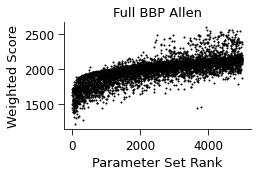

In [11]:
bbp_full_allen_opt_path = 'results/{}/allen{}_opt.hdf5'.format(model_num,model_num)

bbp_full_allen_score_path = './scores_14_params/'
bbp_full_allen_plot_path = './plots/'
plot_comb_scores(bbp_full_allen_opt_path, bbp_full_allen_score_path, 'Full BBP Allen', bbp_full_allen_plot_path)
print('Stims used to train:')
train_stim_names = h5py.File(bbp_full_allen_opt_path, 'r')['opt_stim_name_list'][:]
for e in train_stim_names:
    print(e.decode('ascii'))


In [12]:
run_name = 'zero_penalty'
run_name = "GPU"

[1.290000e-05 9.000000e+01 3.137968e+00 8.925900e-02 6.827000e-03
 9.735380e-01 5.021945e+00 8.752000e-03 9.900000e-04 3.234720e-02
 9.940000e-04 9.839550e-01 3.330000e-04 2.000000e-04 2.320000e+00
 5.000000e-01]


[1.0992593513516516e-05,
 75.98512709627487,
 3.3580454610424244,
 0.025658725745095076,
 0.00013818370801665618,
 2.299076127025784,
 0.7712832839541113]

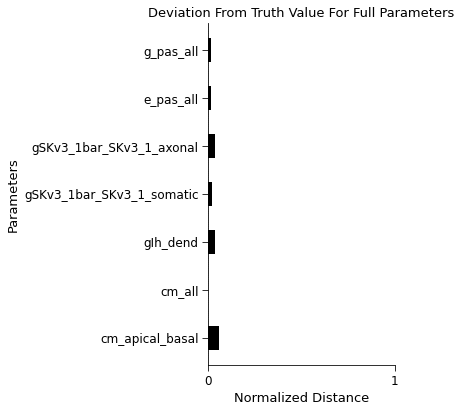

In [18]:
GA_result_path = 'results/{}/best_indvs_{}.pkl'.format(model_num,model_num)
GA_result_path = 'neuron_genetic_alg/best_indv_logs/best_indvs_gen_29.pkl'

params_path = 'neuron_genetic_alg/params/params_bbp_full_gpu_tuned_10_based.csv'
df = pd.read_csv(params_path, skipinitialspace=True, usecols=['Base value'])
base_full = df.values.T[0]
#base_full = bbp_params_base
#opt_ind = [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
opt_ind = [0, 1, 6,9, 13,14,15]

base = [base_full[i] for i in opt_ind]
lbs = [0.1*p for p in base]
ubs = [10*p for p in base]
params_bbp_full = [params_bbp[i] for i in opt_ind]
normalized_indvs_full_bbp, best_indvs_full_bbp = read_and_normalize_with_neg(GA_result_path, base, lbs, ubs)
file_path_to_save = './plots/'
final_indv_plot(params_bbp_full, normalized_indvs_full_bbp[-1], 'For Full Parameters', file_path_to_save, 1, 16)
print(base_full)
best_indvs_full_bbp[-1]

In [19]:
df = pd.read_csv(params_path, skipinitialspace=True, usecols=['Param name','Lower bound', 'Upper bound'])
lbs = df['Lower bound']
ubs = df['Upper bound']
names = df['Param name']

In [20]:
best_full = list(base_full)
for i in range(len(opt_ind)):
    best_full[opt_ind[i]] = best_indvs_full_bbp[-1][i]
#best_full[-1] = 4.121212121e-03
best_full[1] = - best_full[1]
# best_full[14] = 3
# best_full[13] = .00001



print("\n\n")
count = 0
for best, lb, ub, name in zip(best_full, lbs, ubs, names):
    if count in opt_ind:
        print(count, "(optimized)", "name :", name, " | best: ", round(best,9) , " | lb: ", round(lb,8), " | ub: ", round(ub,8))

    else:
        print(count, "name :", name, " | best: ", round(best,9) , " | lb: ", round(lb,8), " | ub: ", round(ub,8))
    print("------------------------------------------------------------")
    count += 1




0 (optimized) name : g_pas_all  | best:  1.0993e-05  | lb:  0.0  | ub:  3.56e-05
------------------------------------------------------------
1 (optimized) name : e_pas_all  | best:  -75.985127096  | lb:  40.0  | ub:  100.0
------------------------------------------------------------
2 name : gNaTa_tbar_NaTa_t_axonal  | best:  3.137968  | lb:  0.3137968  | ub:  31.37968
------------------------------------------------------------
3 name : gK_Tstbar_K_Tst_axonal  | best:  0.089259  | lb:  0.0089259  | ub:  0.89259
------------------------------------------------------------
4 name : gNap_Et2bar_Nap_Et2_axonal  | best:  0.006827  | lb:  0.0006827  | ub:  0.06827
------------------------------------------------------------
5 name : gK_Pstbar_K_Pst_axonal  | best:  0.973538  | lb:  0.0973538  | ub:  9.73538
------------------------------------------------------------
6 (optimized) name : gSKv3_1bar_SKv3_1_axonal  | best:  3.358045461  | lb:  0.00010219  | ub:  10.21945
-----------------

finshed run matrix
finshed run matrix


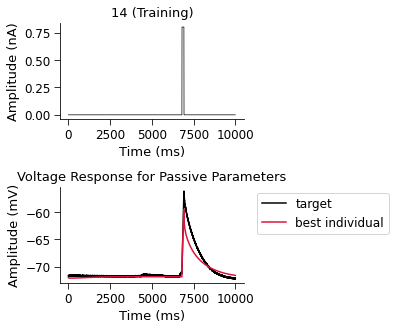

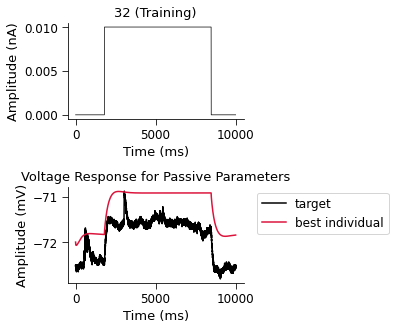

In [21]:
train_volts_full_best_response1 = run_single_volts(best_full, train_stim1, ntimestep=10000, dt=train_stim1_dt)
file_save_path = './plots/'
plot_stim_volts_pair(train_stim1, [train_target_volts1, train_volts_full_best_response1], train_stim1_name+' (Training)', 'for Passive Parameters', file_save_path)

train_volts_full_best_response2 = run_single_volts(best_full, train_stim2, ntimestep=10000, dt=train_stim2_dt)
file_save_path = './plots/'
plot_stim_volts_pair(train_stim2, [train_target_volts2, train_volts_full_best_response2], train_stim2_name+' (Training)', 'for Passive Parameters', file_save_path)


finshed run matrix
finshed run matrix


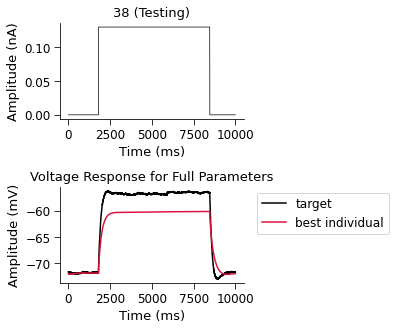

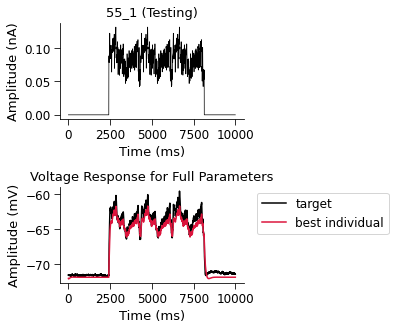

In [22]:
test_volts_full_best_response1 = run_single_volts(best_full, test_stim1, ntimestep=10000, dt=test_stim1_dt)
file_save_path = './plots/'
plot_stim_volts_pair(test_stim1, [test_target_volts1, test_volts_full_best_response1], test_stim1_name+' (Testing)', 'for Full Parameters', file_save_path)

test_volts_full_best_response2 = run_single_volts(best_full, test_stim2, ntimestep=10000, dt=test_stim2_dt)
file_save_path = './plots/'
plot_stim_volts_pair(test_stim2, [test_target_volts2, test_volts_full_best_response2], test_stim2_name+' (Testing)', 'for Full Parameters', file_save_path)


In [18]:
ap_tune_stim_name = '60_2'#'60_2'#'44'
# 4
# 23
# 22
# 48_3
# 53_3
# 51_1
# 58
# 48_1
# 66
# 48_2
# 38
# 28
# 13
print(stims.keys())
ap_tune_stim = stims[ap_tune_stim_name][:]
ap_tune_stim_dt = stims[ap_tune_stim_name+'_dt'][0]
ap_tune_target_response = target_volts[ap_tune_stim_name][:]
ap_tune_best_response = run_single_volts(best_full, ap_tune_stim*2, ntimestep=10000, dt=ap_tune_stim_dt)
file_save_path = './plots/'
plot_stim_volts_pair(ap_tune_stim, [ap_tune_target_response, ap_tune_best_response], ap_tune_stim_name+' (Testing)', 'for Full Parameters', file_save_path)


<KeysViewHDF5 ['101', '101_dt', '102', '102_dt', '103', '103_dt', '11', '11_dt', '12', '12_dt', '13', '13_dt', '16', '16_dt', '17', '17_dt', '19', '19_dt', '21', '21_dt', '26', '26_dt', '27', '27_dt', '30', '30_dt', '32', '32_dt', '33', '33_dt', '34', '34_dt', '35', '35_dt', '38', '38_dt', '39', '39_dt', '8', '8_dt']>


KeyError: "Unable to open object (object '60_2' doesn't exist)"

In [27]:
'6', '27', '26', '60_3', '55_3', '55_1', '52', '60_1', '44',
       '60_2', '42', '32', '13'

IndentationError: unexpected indent (<ipython-input-27-08b964da25a6>, line 2)